Import necessary modules.

In [53]:
# Had some kind of issue with torch installation
# relating to cached version of torch in google colab/version issues,
# if necessary uncomment this:

#!pip uninstall torch -y
#!pip cache purge
#!pip install torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


Load and Preprocess the Data from .csv files.

In [54]:
# Load the data
training_data = pd.read_csv('/content/Data_Files_2023/epl-training.csv')

# Convert 'FTR' column to string type to ensure consistency
training_data['FTR'] = training_data['FTR'].astype(str)

# Handle missing values
training_data.fillna(0, inplace=True)

# Define features and target
features = ['HomeTeam', 'AwayTeam', 'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS',
            'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']
target = 'FTR'

# Convert categorical columns to string type
categorical_features = ['HomeTeam', 'AwayTeam', 'HTR', 'Referee']
for col in categorical_features:
    training_data[col] = training_data[col].astype(str)

# Splitting data
X = training_data[features]
y = training_data[target]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing
numerical_features = [f for f in features if f not in categorical_features]
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)


Define neural network architecture/class.

In [57]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.astype(np.float32).toarray())
X_val_tensor = torch.tensor(X_val.astype(np.float32).toarray())

# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

y_train_tensor = torch.tensor(y_train_encoded)
y_val_tensor = torch.tensor(y_val_encoded)

# Create Tensor datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# DataLoader for batching
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Neural Network architecture
class NN1MatchPredictor(nn.Module):
    def __init__(self, input_size, output_size):
        super(NN1MatchPredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


Initialise and train model.

In [58]:
# Model, loss, and optimizer
input_size = X_train_tensor.shape[1]
output_size = len(label_encoder.classes_)
modelNN1 = NN1MatchPredictor(input_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelNN1.parameters(), lr=0.001)

# Training loop
epochs = 20
for epoch in range(epochs):
    modelNN1.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = modelNN1(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation
    modelNN1.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            output = modelNN1(X_batch)
            loss = criterion(output, y_batch)
            val_loss += loss.item()

    if epoch%1 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Training Loss: {total_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f}")


Epoch 1/20 - Training Loss: 0.9277, Validation Loss: 0.7492
Epoch 2/20 - Training Loss: 0.7444, Validation Loss: 0.7323
Epoch 3/20 - Training Loss: 0.7225, Validation Loss: 0.7385
Epoch 4/20 - Training Loss: 0.7057, Validation Loss: 0.7394
Epoch 5/20 - Training Loss: 0.6919, Validation Loss: 0.7436
Epoch 6/20 - Training Loss: 0.6714, Validation Loss: 0.7489
Epoch 7/20 - Training Loss: 0.6546, Validation Loss: 0.7528
Epoch 8/20 - Training Loss: 0.6312, Validation Loss: 0.7657
Epoch 9/20 - Training Loss: 0.6102, Validation Loss: 0.7745
Epoch 10/20 - Training Loss: 0.5806, Validation Loss: 0.8028
Epoch 11/20 - Training Loss: 0.5534, Validation Loss: 0.8267
Epoch 12/20 - Training Loss: 0.5237, Validation Loss: 0.8499
Epoch 13/20 - Training Loss: 0.4927, Validation Loss: 0.8891
Epoch 14/20 - Training Loss: 0.4613, Validation Loss: 0.9388
Epoch 15/20 - Training Loss: 0.4353, Validation Loss: 0.9728
Epoch 16/20 - Training Loss: 0.4017, Validation Loss: 1.0149
Epoch 17/20 - Training Loss: 0.37

Lets try a NN architecture with dropout layers + early stopping

In [62]:
# Neural Network architecture with Dropout
class NN2MatchPredictor(nn.Module):
    def __init__(self, input_size, output_size):
        super(NN2MatchPredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.dropout1 = nn.Dropout(0.5)  # Adding dropout
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)  # Adding dropout
        self.fc3 = nn.Linear(64, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)  # Applying dropout
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)  # Applying dropout
        x = self.fc3(x)
        return x


Initialise and train this 2nd NN model:

In [63]:
# Early stopping parameters
early_stopping_threshold = 5
min_val_loss = float('inf')
no_improve_epochs = 0

modelNN2 = NN2MatchPredictor(input_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizerNN2 = torch.optim.Adam(modelNN2.parameters(), lr=0.001)

epochs = 20
# Training loop with early stopping
for epoch in range(epochs):
    modelNN2.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizerNN2.zero_grad()
        output = modelNN2(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizerNN2.step()
        total_loss += loss.item()

    # Validation
    modelNN2.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            output = modelNN2(X_batch)
            loss = criterion(output, y_batch)
            val_loss += loss.item()

    if epoch%1 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Training Loss: {total_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f}")

    #early stopping
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1

    if no_improve_epochs >= early_stopping_threshold:
        print("Early stopping triggered")
        break


Epoch 1/20 - Training Loss: 0.9763, Validation Loss: 0.7523
Epoch 2/20 - Training Loss: 0.7905, Validation Loss: 0.7396
Epoch 3/20 - Training Loss: 0.7726, Validation Loss: 0.7331
Epoch 4/20 - Training Loss: 0.7614, Validation Loss: 0.7316
Epoch 5/20 - Training Loss: 0.7495, Validation Loss: 0.7408
Epoch 6/20 - Training Loss: 0.7394, Validation Loss: 0.7332
Epoch 7/20 - Training Loss: 0.7293, Validation Loss: 0.7347
Epoch 8/20 - Training Loss: 0.7255, Validation Loss: 0.7370
Epoch 9/20 - Training Loss: 0.7121, Validation Loss: 0.7347
Early stopping triggered


Lets try a CNN architecture:

In [42]:
class CNNMatchPredictor(nn.Module):
    def __init__(self, num_features, num_classes):
        super(CNNMatchPredictor, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=num_channels, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, start_dim=1)  # Flatten the output for the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


Train CNN

In [43]:
# Model instantiation
num_channels = X_train_tensor.shape[2]  # Assuming X_train_tensor is reshaped appropriately
num_classes = len(torch.unique(y_train_tensor))

modelCNN = CNNMatchPredictor(num_channels, num_classes)

# Training loop
epochs = 20
for epoch in range(epochs):
    modelCNN.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = modelCNN(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation
    modelCNN.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            output = modelCNN(X_batch)
            loss = criterion(output, y_batch)
            val_loss += loss.item()

    if epoch%1 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Training Loss: {total_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f}")


IndexError: ignored

Lets Try RNN architecture:

In [65]:
class MatchPredictorRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(MatchPredictorRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

Train the RNN

In [66]:
# Model parameters
input_size = X_train_tensor.shape[1]  # Number of features
hidden_size = 128  # You can adjust this
output_size = 3  # Assuming 3 classes: Home win, Draw, Away win
num_layers = 2  # Number of RNN layers

# Create the model
modelRNN = MatchPredictorRNN(input_size, hidden_size, output_size, num_layers)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelRNN.parameters(), lr=0.001)

# Training loop
epochs = 10  # You can adjust this
for epoch in range(epochs):
    modelRNN.train()  # Set the model to training mode
    total_loss = 0
    for batch in train_loader:  # Assuming you have a DataLoader named 'train_loader'
        inputs, labels = batch

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = modelRNN(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Calculate average loss over the epoch
    avg_loss = total_loss / len(train_loader)

    # Validation step (if you have a validation set)
    modelRNN.eval()  # Set the model to evaluation mode
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:  # Assuming you have a DataLoader named 'val_loader'
            inputs, labels = batch
            outputs = modelRNN(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

RuntimeError: ignored

Plot confusion matrix/accuracy

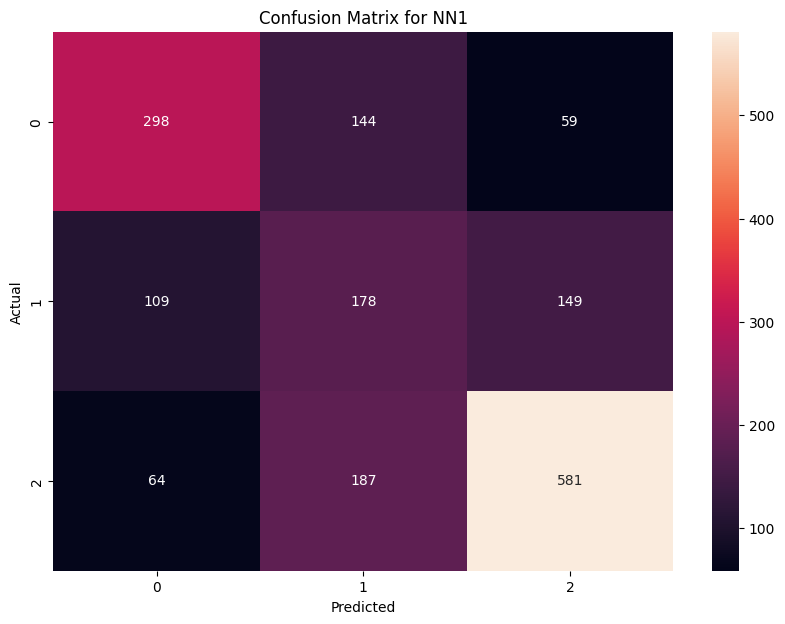

NN1 Accuracy: 59.75%


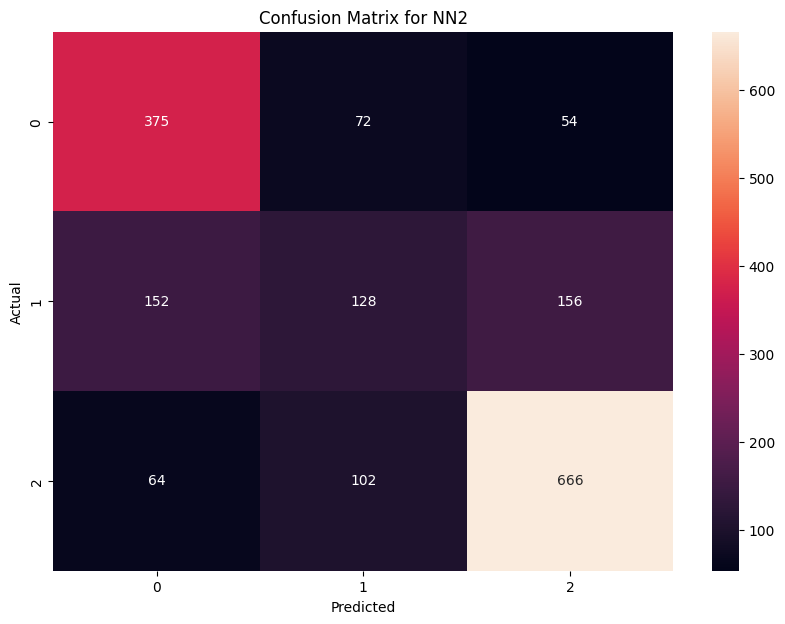

NN2 Accuracy: 66.08%


In [64]:
# Function to calculate predictions
def get_predictions(model, data_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for X, y in data_loader:
            outputs = model(X)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.tolist())
            actuals.extend(y.tolist())
    return actuals, predictions

# Function to plot confusion matrix
def plot_confusion_matrix(actuals, predictions, title):
    cm = confusion_matrix(actuals, predictions)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# Function to calculate and print accuracy
def print_accuracy(actuals, predictions, title):
    accuracy = accuracy_score(actuals, predictions)
    print(f"{title} Accuracy: {accuracy * 100:.2f}%")

# Get predictions for both models
actuals_nn1, predictions_nn1 = get_predictions(modelNN1, val_loader)  # Replace 'model' with your NN1 model instance
actuals_nn2, predictions_nn2 = get_predictions(modelNN2, val_loader)  # Replace 'model' with your NN2 model instance

# Plot confusion matrices and print accuracy
plot_confusion_matrix(actuals_nn1, predictions_nn1, "Confusion Matrix for NN1")
print_accuracy(actuals_nn1, predictions_nn1, "NN1")

plot_confusion_matrix(actuals_nn2, predictions_nn2, "Confusion Matrix for NN2")
print_accuracy(actuals_nn2, predictions_nn2, "NN2")